# Create a logistic regression model to predict TP53 mutation from gene expression data in TCGA

In [1]:
import os
import time
import datetime
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from vega import Vega
import json
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA

from utils import fill_spec_with_data, get_model_coefficients

In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')

## Specify model configuration

In [3]:
# We're going to be building a 'TP53' classifier 
GENE = '7157' # TP53

*Here is some [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) regarding the classifier and hyperparameters*

*Here is some [information](https://ghr.nlm.nih.gov/gene/TP53) about TP53*

## Load Data

In [4]:
%%time
path = os.path.join('download', 'expression-matrix.tsv.bz2')
expression = pd.read_table(path, index_col=0)

CPU times: user 1min 23s, sys: 6.2 s, total: 1min 30s
Wall time: 1min 31s


In [5]:
%%time
path = os.path.join('download', 'mutation-matrix.tsv.bz2')
Y = pd.read_table(path, index_col=0)

CPU times: user 51.9 s, sys: 300 ms, total: 52.2 s
Wall time: 52.3 s


In [6]:
%%time
path = os.path.join('download', 'covariates.tsv')
covariates = pd.read_table(path, index_col=0)

# Select acronym_x and n_mutations_log1p covariates only
selected_cols = [col for col in covariates.columns if 'acronym_' in col]
selected_cols.append('n_mutations_log1p')
covariates = covariates[selected_cols]

CPU times: user 40 ms, sys: 0 ns, total: 40 ms
Wall time: 45.4 ms


In [7]:
y = Y[GENE]

In [8]:
# The Series now holds TP53 Mutation Status for each Sample
y.head(6)

sample_id
TCGA-02-0047-01    0
TCGA-02-0055-01    1
TCGA-02-2483-01    1
TCGA-02-2485-01    1
TCGA-02-2486-01    0
TCGA-04-1348-01    1
Name: 7157, dtype: int64

In [9]:
# Here are the percentage of tumors with TP53
y.value_counts(True)

0    0.645907
1    0.354093
Name: 7157, dtype: float64

In [10]:
print('Gene expression matrix shape: {0[0]}, {0[1]}'.format(expression.shape))
print('Covariates matrix shape: {0[0]}, {0[1]}'.format(covariates.shape))

Gene expression matrix shape: 7306, 20468
Covariates matrix shape: 7306, 33


## Set aside 10% of the data for testing

In [11]:
# Typically, this type of split can only be done 
# for genes where the number of mutations is large enough
X = pd.concat([covariates, expression], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

## Feature selection

In [12]:
# Select the feature set for the different models within the pipeline
n_covariates = len(covariates.columns)
def select_feature_set_columns(X, feature_set):
    if feature_set=='expressions': return X[:, n_covariates:]
    return  X[:, :n_covariates]

# Creates the expression features by standarizing them and running PCA
# Because the expressions matrix is so large, we preprocess with PCA
# The amount of variance in the data captured by ~100 components is high
expression_features = Pipeline([
    ('select_features', FunctionTransformer(select_feature_set_columns,
        kw_args={'feature_set': 'expressions'})),
    ('standardize', StandardScaler()),
    ('pca', PCA())
])

# Creates the covariate features by selecting and standardizing them
covariate_features = Pipeline([
    ('select_features', FunctionTransformer(select_feature_set_columns,
        kw_args={'feature_set': 'covariates'})),
    ('standardize', StandardScaler())
])

## Elastic net classifier and model paraemeters

In [13]:
# Parameter Sweep for Hyperparameters
n_components_list = [50, 100]
regularization_alpha_list = [10 ** x for x in range(-3, 1)]
regularization_l1_ratio = 0.15

param_grids = {
    'full': {
        'features__expressions__pca__n_components' : n_components_list,
        'classify__alpha': regularization_alpha_list
    },
    'expressions': {
        'features__expressions__pca__n_components' : n_components_list,
        'classify__alpha': regularization_alpha_list
    },
    'covariates': {
        'classify__alpha': regularization_alpha_list
    }
}

# Classifier: Elastic Net
classifier = SGDClassifier(penalty='elasticnet',
                           l1_ratio=regularization_l1_ratio,
                           loss='log', 
                           class_weight='balanced',
                           random_state=0)

## Define pipeline and cross validation

In [14]:
# Full model pipelines
pipeline_definitions = {
    'full': Pipeline([
        ('features', FeatureUnion([
            ('expressions', expression_features),
            ('covariates', covariate_features)
        ])),
        ('classify', classifier)
    ]),
    'expressions': Pipeline([
        ('features', FeatureUnion([('expressions', expression_features)])),
        ('classify', classifier)
    ]),
    'covariates': Pipeline([
        ('features', FeatureUnion([('covariates', covariate_features)])),
        ('classify', classifier)
    ])
}

models = ['full', 'expressions', 'covariates']

cv_pipelines = {mod: GridSearchCV(estimator=pipeline, 
                                  param_grid=param_grids[mod], 
                                  n_jobs=1, 
                                  scoring='roc_auc') 
                for mod, pipeline in pipeline_definitions.items()}

In [15]:
st = time.perf_counter()

# Fit the models
for model, pipeline in cv_pipelines.items():
    print('Fitting CV for model: {0}'.format(model))
    pipeline.fit(X=X_train, y=y_train)
    
et = time.perf_counter()
print('Time to fit models: {0}'.format(str(datetime.timedelta(seconds=et-st))))

Fitting CV for model: expressions
Fitting CV for model: covariates
Fitting CV for model: full
Time to fit models: 0:08:12.280509


In [16]:
# Best Parameters
for model, pipeline in cv_pipelines.items():
    print('{0}: {1:.3%}'.format(model, pipeline.best_score_))

    print(pipeline.best_params_)

expressions: 87.952%
{'features__expressions__pca__n_components': 50, 'classify__alpha': 1}
covariates: 84.206%
{'classify__alpha': 0.01}
full: 87.616%
{'features__expressions__pca__n_components': 100, 'classify__alpha': 1}


## Visualize hyperparameters performance

In [17]:
cv_results_df = pd.DataFrame()
for model, pipeline in cv_pipelines.items():
    df = pd.concat([
        pd.DataFrame(pipeline.cv_results_),
        pd.DataFrame.from_records(pipeline.cv_results_['params'])
    ], axis='columns')
    df['feature_set'] = model
    cv_results_df = cv_results_df.append(df)

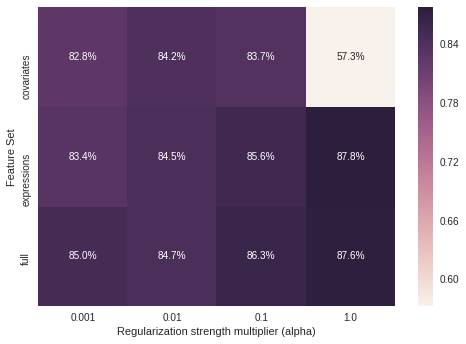

In [18]:
# Cross-validated performance heatmap
cv_score_mat = pd.pivot_table(cv_results_df,
                              values='mean_test_score', 
                              index='feature_set',
                              columns='classify__alpha')
ax = sns.heatmap(cv_score_mat, annot=True, fmt='.1%')
ax.set_xlabel('Regularization strength multiplier (alpha)')
ax.set_ylabel('Feature Set');

## Use optimal hyperparameters to output ROC curve

In [19]:
y_pred_dict = {
    model: {
        'train': pipeline.decision_function(X_train),
        'test':  pipeline.decision_function(X_test)
    } for model, pipeline in cv_pipelines.items()
}

def get_threshold_metrics(y_true, y_pred):
    roc_columns = ['fpr', 'tpr', 'threshold']
    roc_items = zip(roc_columns, roc_curve(y_true, y_pred))
    roc_df = pd.DataFrame.from_items(roc_items)
    auroc = roc_auc_score(y_true, y_pred)
    return {'auroc': auroc, 'roc_df': roc_df}

metrics_dict = {    
    model: {
        'train': get_threshold_metrics(y_train, y_pred_dict[model]['train']),
        'test':  get_threshold_metrics(y_test, y_pred_dict[model]['test'])
    } for model in y_pred_dict.keys()
}

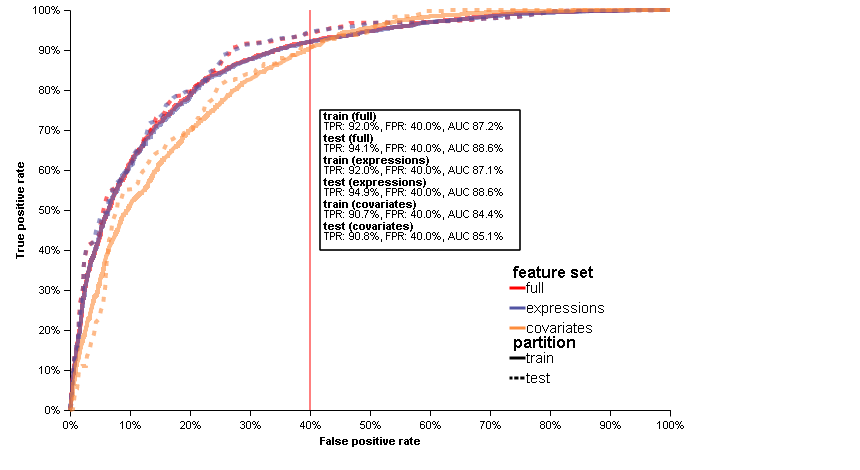

In [20]:
# Assemble the data for ROC curves
model_order = ['full', 'expressions', 'covariates']

auc_output = pd.DataFrame()
roc_output = pd.DataFrame()

for model in model_order:
    metrics_partition = metrics_dict[model]
    for partition, metrics in metrics_partition.items():
        auc_output = auc_output.append(pd.DataFrame({
            'partition': [partition],
            'feature_set': [model],
            'auc': metrics['auroc']
        }))
        roc_df = metrics['roc_df']
        roc_output = roc_output.append(pd.DataFrame({
            'false_positive_rate': roc_df.fpr,
            'true_positive_rate': roc_df.tpr,
            'partition': partition,
            'feature_set': model
        }))
auc_output['legend_index'] = range(len(auc_output.index))

with open('vega_specs/roc_vega_spec.json', 'r') as fp:
    vega_spec = json.load(fp)

final_spec = fill_spec_with_data(vega_spec, 
    {'roc': roc_output, 'legend_auc': auc_output})

Vega(final_spec)

## What are the classifier coefficients?

In [21]:
final_pipelines = {
    model: pipeline.best_estimator_
    for model, pipeline in cv_pipelines.items()
}
final_classifiers = {
    model: pipeline.named_steps['classify']
    for model, pipeline in final_pipelines.items()
}

coef_df = pd.concat([
    get_model_coefficients(classifier, model, covariates.columns)
    for model, classifier in final_classifiers.items()
])

In [22]:
def zero(w): return '{:.1%}'.format(np.mean(w == 0))
def negative(w): return '{:,}'.format(np.sum(w < 0))
def positive(w): return '{:,}'.format(np.sum(w > 0))

coef_df.groupby('feature_set')['weight'].agg([zero, negative, positive])

,zero,negative,positive
feature_set,,,
covariates,15.2%,15.0,13.0
expressions,50.0%,13.0,12.0
full,80.5%,14.0,12.0


In [23]:
model = 'full'
model_coef_df = coef_df[coef_df['feature_set'] == model]
model_coef_df.head(10)

,feature,weight,abs,feature_set
8,PCA_8,-0.038587,0.038587,full
2,PCA_2,-0.036588,0.036588,full
29,PCA_29,-0.035830,0.035830,full
11,PCA_11,-0.034146,0.034146,full
24,PCA_24,0.032964,0.032964,full
22,PCA_22,-0.031807,0.031807,full
37,PCA_37,0.029421,0.029421,full
1,PCA_1,-0.028661,0.028661,full
17,PCA_17,0.026552,0.026552,full
34,PCA_34,-0.023754,0.023754,full


## Investigate the predictions

In [24]:
predict_df = pd.DataFrame()
for model, pipeline in final_pipelines.items():
    df = pd.DataFrame.from_items([
        ('feature_set', model),
        ('sample_id', X.index),
        ('test_set', X.index.isin(X_test.index).astype(int)),
        ('status', y),
        ('decision_function', pipeline.decision_function(X)),
        ('probability', pipeline.predict_proba(X)[:, 1])
    ])    
    predict_df = predict_df.append(df)

predict_df['probability_str'] = predict_df['probability'].apply('{:.1%}'.format)

In [25]:
# Top predictions amongst negatives (potential hidden responders)
model = 'full'
predict_df.sort_values('decision_function', ascending=False).\
    query("status == 0 & feature_set == '{0}'".format(model)).head(10)

,feature_set,sample_id,test_set,status,decision_function,probability,probability_str
sample_id,,,,,,,
TCGA-L5-A4OH-01,full,TCGA-L5-A4OH-01,0,0,4.014282,0.982264,98.2%
TCGA-L5-A8NR-01,full,TCGA-L5-A8NR-01,0,0,3.755536,0.977147,97.7%
TCGA-EI-6513-01,full,TCGA-EI-6513-01,1,0,3.520989,0.971279,97.1%
TCGA-HF-7136-01,full,TCGA-HF-7136-01,0,0,3.393010,0.967485,96.7%
TCGA-21-1081-01,full,TCGA-21-1081-01,0,0,3.392895,0.967482,96.7%
TCGA-E2-A1LI-01,full,TCGA-E2-A1LI-01,0,0,3.365988,0.966625,96.7%
TCGA-L5-A4OS-01,full,TCGA-L5-A4OS-01,0,0,3.223450,0.961707,96.2%
TCGA-B6-A0I1-01,full,TCGA-B6-A0I1-01,0,0,3.145106,0.958715,95.9%
TCGA-BR-A4J1-01,full,TCGA-BR-A4J1-01,0,0,3.124487,0.957892,95.8%


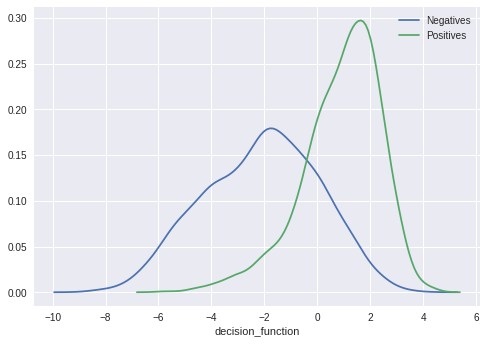

In [26]:
# Ignore numpy warning caused by seaborn
warnings.filterwarnings('ignore', 'using a non-integer number instead of an integer')

model = 'full'
model_predict_df = predict_df[predict_df['feature_set'] == model]

ax = sns.distplot(model_predict_df.query("status == 0").decision_function, hist=False, label='Negatives')
ax = sns.distplot(model_predict_df.query("status == 1").decision_function, hist=False, label='Positives')

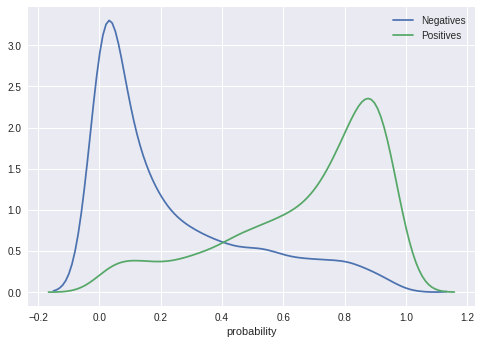

In [27]:
ax = sns.distplot(model_predict_df.query("status == 0").probability, hist=False, label='Negatives')
ax = sns.distplot(model_predict_df.query("status == 1").probability, hist=False, label='Positives')